In [1]:
import pandas as pd
import numpy as np
import shared
import json


In [2]:
ve_or_ju = "ve"

In [3]:
import time

startTime = time.time()

In [4]:
runs_orig = pd.read_csv(f'data/runs_{ve_or_ju}.tsv', delimiter="\t")


In [5]:
country_counts = runs_orig["team_country"].value_counts()
top_country_counts = country_counts[country_counts > 100]
top_countries = top_country_counts.keys().tolist()
display(top_countries)

with open(f"data/top_countries_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_countries, outfile)

['FIN', 'SWE', 'NOR', 'RUS', 'LAT', 'EST', 'SUI', 'GBR']

In [6]:
runs_orig["first_name"] = runs_orig.name.str.split(" ", expand=True).iloc[:, 0]
runs_df = runs_orig
runs_df.head()

,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name
0,anna mårsell,2018,3,STORA TUNA OK,SWE,6.441,1,4,anna
1,anna mårsell,2017,7,STORA TUNA OK,SWE,7.214,1,4,anna
2,anna mårsell,2016,22,STORA TUNA OK,SWE,6.291,1,4,anna
3,anna mårsell,2011,40,STORA TUNA OK,SWE,6.497,2,4,anna
4,magdalena olsson,2018,3,STORA TUNA OK,SWE,6.511,2,7,magdalena


In [7]:
fn_counts = runs_df["first_name"].value_counts()
top_fn_counts = fn_counts[fn_counts > 20]
top_first_names = top_fn_counts.keys().tolist()

with open(f"data/top_first_names_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_first_names, outfile)

In [8]:
# Temporarily remove 2018 in order to try predict it in other notebook
#runs_df = runs_df[runs_df.year != 2018]
#runs_df

In [9]:
features = shared.preprocess_features(runs_df, top_countries, ve_or_ju)
features.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39906 entries, 0 to 39905
Data columns (total 9 columns):
name            39906 non-null object
year            39906 non-null int64
team_id         39906 non-null int64
team            39906 non-null object
team_country    39906 non-null object
pace            39906 non-null float64
leg_nro         39906 non-null int64
num_runs        39906 non-null int64
first_name      39906 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 2.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 4 columns):
first_name           974 non-null object
mean_pace_count      975 non-null int64
fn_pace_class        975 non-null int64
fn_pace_std_class    975 non-null int64
dtypes: int64(3), object(1)
memory usage: 30.6+ KB


None

[]

,team_id,team_id_log10,team_id_square,leg_1,leg_2,leg_3,leg_4,c_EST,c_FIN,c_GBR,...,fn_pace_class_6.0,fn_pace_class_7.0,fn_pace_class_8.0,fn_pace_class_9.0,fn_pace_class_nan,fn_pace_std_class_0.0,fn_pace_std_class_1.0,fn_pace_std_class_2.0,fn_pace_std_class_3.0,fn_pace_std_class_nan
0,3,0.477121,9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7,0.845098,49,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,22,1.342423,484,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40,1.602060,1600,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,0.477121,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,7,0.845098,49,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,28,1.447158,784,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,32,1.505150,1024,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,27,1.431364,729,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,34,1.531479,1156,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39906 entries, 0 to 39905
Data columns (total 41 columns):
team_id                  -39906 non-null int64
team_id_log10            -39906 non-null float64
team_id_square           -39906 non-null int64
leg_1                    -39906 non-null Sparse[uint8, 0]
leg_2                    -39906 non-null Sparse[uint8, 0]
leg_3                    -39906 non-null Sparse[uint8, 0]
leg_4                    -39906 non-null Sparse[uint8, 0]
c_EST                    -39906 non-null Sparse[uint8, 0]
c_FIN                    -39906 non-null Sparse[uint8, 0]
c_GBR                    -39906 non-null Sparse[uint8, 0]
c_LAT                    -39906 non-null Sparse[uint8, 0]
c_NOR                    -39906 non-null Sparse[uint8, 0]
c_OTHER                  -39906 non-null Sparse[uint8, 0]
c_RUS                    -39906 non-null Sparse[uint8, 0]
c_SUI                    -39906 non-null Sparse[uint8, 0]
c_SWE                    -39906 non-null Sparse[uint

In [11]:
x = features.values
#x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
y = np.log(runs_df.pace.values)
y = y.reshape(len(y), 1)

display(x.shape)
display(y.shape)

(39906, 41)

(39906, 1)

In [12]:
reports = [f'x.shape: {x.shape}', f'y.shape: {y.shape}', features.info()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39906 entries, 0 to 39905
Data columns (total 41 columns):
team_id                  -39906 non-null int64
team_id_log10            -39906 non-null float64
team_id_square           -39906 non-null int64
leg_1                    -39906 non-null Sparse[uint8, 0]
leg_2                    -39906 non-null Sparse[uint8, 0]
leg_3                    -39906 non-null Sparse[uint8, 0]
leg_4                    -39906 non-null Sparse[uint8, 0]
c_EST                    -39906 non-null Sparse[uint8, 0]
c_FIN                    -39906 non-null Sparse[uint8, 0]
c_GBR                    -39906 non-null Sparse[uint8, 0]
c_LAT                    -39906 non-null Sparse[uint8, 0]
c_NOR                    -39906 non-null Sparse[uint8, 0]
c_OTHER                  -39906 non-null Sparse[uint8, 0]
c_RUS                    -39906 non-null Sparse[uint8, 0]
c_SUI                    -39906 non-null Sparse[uint8, 0]
c_SWE                    -39906 non-null Sparse[uint

In [13]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)
x_train.shape

(31924, 41)

In [15]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))

    reports.append(f'{type(model)}: {model.get_params()}')
    reports.append(f'Explained variance score: {r2_score(np.exp(y_test), y_pred).round(3)}')
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [16]:
y_train.shape

(31924, 1)

Shapes: y_test=(7982, 1) y_pred=(7982,)
Mean squared error: 5.412
Explained variance score: 0.432


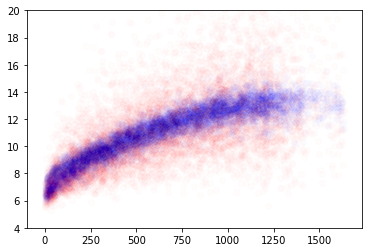

CPU times: user 794 ms, sys: 451 ms, total: 1.25 s
Wall time: 350 ms


In [17]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

In [18]:
pd.DataFrame({'name':features.keys(), 'coef':linear.coef_})

,name,coef
0,team_id,6.280506e-04
1,team_id_log10,5.656698e-02
2,team_id_square,-2.422567e-07
3,leg_1,-4.535280e-02
4,leg_2,-3.169213e-03
5,leg_3,2.878222e-02
6,leg_4,1.973980e-02
7,c_EST,4.014702e-02
8,c_FIN,6.032230e-02
9,c_GBR,-1.479864e-02


      Iter       Train Loss   Remaining Time 
         1           0.0634            3.93m
         2           0.0584            3.81m
         3           0.0543            3.86m
         4           0.0509            3.79m
         5           0.0482            3.67m
         6           0.0460            3.70m
         7           0.0441            3.63m
         8           0.0426            3.60m
         9           0.0414            3.64m
        10           0.0403            3.67m
        20           0.0357            3.55m
        30           0.0343            3.21m
        40           0.0337            3.11m
        50           0.0333            2.89m
        60           0.0330            2.77m
        70           0.0329            2.68m
        80           0.0327            2.61m
        90           0.0326            2.54m
       100           0.0325            2.48m
       200           0.0319            2.24m
       300           0.0314            2.32m
       40

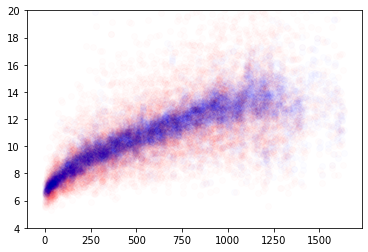

CPU times: user 2min 40s, sys: 571 ms, total: 2min 40s
Wall time: 2min 40s


In [19]:
%%time
gbr_num_estimators=5100
gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=gbr_num_estimators, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [20]:
gbr_num_estimators_quantile=int(gbr_num_estimators/5)

      Iter       Train Loss   Remaining Time 
         1           0.0590           50.84s
         2           0.0565           50.54s
         3           0.0543           50.62s
         4           0.0524           50.70s
         5           0.0508           50.82s
         6           0.0493           51.08s
         7           0.0480           51.47s
         8           0.0469           51.42s
         9           0.0460           51.41s
        10           0.0453           51.23s
        20           0.0417           52.13s
        30           0.0407           53.39s
        40           0.0403           52.18s
        50           0.0401           50.20s
        60           0.0400           48.69s
        70           0.0399           47.19s
        80           0.0398           45.75s
        90           0.0397           44.35s
       100           0.0396           43.39s
       200           0.0393           36.21s
       300           0.0392           30.27s
       40

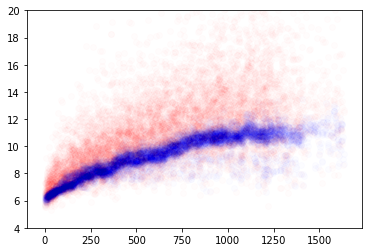

In [21]:
gbr_q_low = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.159, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_low, x_train, x_test, y_train, y_test)


      Iter       Train Loss   Remaining Time 
         1           0.0631           56.44s
         2           0.0611           56.33s
         3           0.0594           57.18s
         4           0.0578           57.05s
         5           0.0565           57.04s
         6           0.0553           56.96s
         7           0.0543           56.65s
         8           0.0534           56.66s
         9           0.0526           56.52s
        10           0.0519           56.30s
        20           0.0482           54.91s
        30           0.0470           52.90s
        40           0.0464           50.77s
        50           0.0461           47.85s
        60           0.0459           45.81s
        70           0.0457           44.30s
        80           0.0456           42.96s
        90           0.0455           41.69s
       100           0.0454           40.62s
       200           0.0451           32.68s
       300           0.0451           27.19s
       40

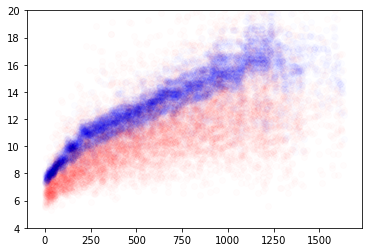

In [22]:
gbr_q_high = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.841, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_high, x_train, x_test, y_train, y_test)



In [23]:
joblib.dump(gbr, f'gbr_{ve_or_ju}.sav')
joblib.dump(gbr_q_low, f'gbr_q_low_{ve_or_ju}.sav')
joblib.dump(gbr_q_high, f'gbr_q_high_{ve_or_ju}.sav')


['gbr_q_high_ve.sav']

In [24]:
gbr_preds = gbr.predict(pd.DataFrame(x_test))
gbr_q_low_preds = gbr_q_low.predict(pd.DataFrame(x_test))
gbr_q_high_preds = gbr_q_high.predict(pd.DataFrame(x_test))

In [25]:
gbr_q_pred_errors = pd.DataFrame({
    'q_low':np.exp(gbr_q_low_preds),
    'true':np.exp(y_test).ravel(), 
    'predicted':np.exp(gbr_preds), 
    'q_high':np.exp(gbr_q_high_preds), 
})

gbr_q_pred_errors["q_low_error"] = gbr_q_pred_errors.true < gbr_q_pred_errors.q_low
gbr_q_pred_errors["q_high_error"] = gbr_q_pred_errors.true > gbr_q_pred_errors.q_high
gbr_q_pred_errors["q_error"] = np.logical_or(gbr_q_pred_errors.q_low_error, gbr_q_pred_errors.q_high_error)
gbr_q_pred_errors["q_interval"] = gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low


gbr_q_pred_errors["std"] = (gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low) / 2
# Intentionally don't use log scale for calculation to get bigger std
# TODO IS this causing big std in Bayesian models? :(
gbr_q_pred_errors["std_correct"] = np.exp((gbr_q_high_preds - gbr_q_low_preds) / 2)
gbr_q_pred_errors["abs_error"] = np.abs(gbr_q_pred_errors.predicted - gbr_q_pred_errors.true)
gbr_q_pred_errors["abs_error_in_stds"] = gbr_q_pred_errors.abs_error / np.exp(gbr_q_pred_errors["std_correct"])

gbr_reports = [
    f'q_low_error.mean {gbr_q_pred_errors.q_low_error.mean().round(4)}',
    f'q_high_error.mean {gbr_q_pred_errors.q_high_error.mean().round(4)}',
    f'q_error.mean {gbr_q_pred_errors.q_error.mean().round(4)}',

    f'q_interval.mean {gbr_q_pred_errors.q_interval.mean().round(4)}',
    f'q_interval.median {gbr_q_pred_errors.q_interval.median().round(4)}',

    f'std.mean {gbr_q_pred_errors["std"].mean().round(4)}',
    f'std_correct.mean {gbr_q_pred_errors["std_correct"].mean().round(4)}',
    f'abs_error_in_stds.mean {gbr_q_pred_errors["abs_error_in_stds"].mean().round(4)}',
    f'abs_error.mean {gbr_q_pred_errors["abs_error"].mean().round(4)}',
    f'abs_error.median {gbr_q_pred_errors["abs_error"].median().round(4)}'
]


display(gbr_q_pred_errors.tail(15).round(3))
display(gbr_reports)


,q_low,true,predicted,q_high,q_low_error,q_high_error,q_error,q_interval,std,std_correct,abs_error,abs_error_in_stds
7967,7.912,7.500,9.038,10.341,True,False,True,2.429,1.215,1.143,1.538,0.490
7968,6.316,7.761,7.510,7.858,False,False,False,1.542,0.771,1.115,0.251,0.082
7969,10.732,14.444,13.287,16.110,False,False,False,5.378,2.689,1.225,1.157,0.340
7970,7.775,8.949,8.673,9.910,False,False,False,2.135,1.067,1.129,0.276,0.089
7971,6.831,6.789,7.887,8.449,True,False,True,1.617,0.809,1.112,1.098,0.361
7972,7.781,8.600,7.906,9.735,False,False,False,1.954,0.977,1.119,0.694,0.227
7973,11.163,12.657,13.767,15.612,False,False,False,4.450,2.225,1.183,1.110,0.340
7974,8.997,9.333,11.514,12.749,False,False,False,3.752,1.876,1.190,2.181,0.663
7975,11.011,9.621,13.001,15.452,True,False,True,4.441,2.221,1.185,3.380,1.034
7976,7.114,8.868,7.991,9.936,False,False,False,2.821,1.411,1.182,0.877,0.269


['q_low_error.mean 0.1681',
 'q_high_error.mean 0.1601',
 'q_error.mean 0.3282',
 'q_interval.mean 3.868',
 'q_interval.median 3.7273',
 'std.mean 1.934',
 'std_correct.mean 1.1853',
 'abs_error_in_stds.mean 0.4941',
 'abs_error.mean 1.6328',
 'abs_error.median 1.2225']

In [26]:
reports.extend(gbr_reports)

In [27]:
gbr_q_pred_errors[['q_error', "q_low", "q_high", "q_interval", "abs_error", "std"]].groupby('q_error').agg(["median"]).round(2)

,q_low,q_high,q_interval,abs_error,std
,median,median,median,median,median
q_error,,,,,
False,9.41,13.25,3.72,0.81,1.86
True,9.47,13.34,3.74,2.55,1.87


In [28]:
endTime = time.time()
reports.append(f"runtime {round(((endTime - startTime)/ 60), 2)} mins")
shared.write_simple_text_report(reports, f'preprocess_priors_{ve_or_ju}.txt')

In [29]:
%%date

UsageError: Cell magic `%%date` not found.


In [ ]:
STOP_HERE

In [ ]:
import os
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
#os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32,force_device=True'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

In [ ]:

pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": multiprocessing.cpu_count() -1,
        #"chains":2,
        "init": 'adapt_diag',
        #"tune": 2000,
        "target_accept": 0.9999
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

In [ ]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

In [ ]:

joblib.dump(pmlearn_linear, 'pmlearn_linear.sav')

In [ ]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(15))
pred_errors.error.mean()

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
summary_df = pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])
summary_df

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])